In [37]:
# @title Setup bigquery client and formatting
from google.cloud import bigquery
from google.colab import data_table

project = 'esdemo-389207' # Project ID
client = bigquery.Client(project=project)
data_table.enable_dataframe_formatter()
# @title Executes the query, using client from previous cell
sql_SQL = '''
WITH historical_sales AS (
  -- This CTE prepares the aggregated historical sales data for each country.
  SELECT
    customers.country,
    orders_dp.order_date, -- This is our timestamp
    SUM(orders_dp.total_amount) AS total_sales -- This is the value we are forecasting
  FROM
    `esdemo-389207`.`retail_data`.`customers` AS customers
  INNER JOIN
    `esdemo-389207`.`retail_data`.`orders_dp` AS orders_dp
    ON customers.customer_id = orders_dp.customer_id
  #WHERE customers.country = 'Sweden' -- <<< PARAMETER: Specify the country to visualize
  GROUP BY
    1,
    2
)

-- Select historical data for Contribution Analysis
SELECT
  h.order_date AS date, -- Date column
  h.country,
  h.total_sales AS historical_value
FROM
  historical_sales h
'''
query_SQL = client.query(sql_SQL)

# store the destination to reference in future cells
query_destination_SQL = query_SQL.destination.project + '.' + query_SQL.destination.dataset_id + '.' + query_SQL.destination.table_id

#  Render the query results
job_SQL= client.get_job(query_SQL.job_id)
df_SQL = job_SQL.to_dataframe()
df_SQL


,date,country,historical_value
0,2025-01-23,Denmark,82073.01
1,2025-04-07,Denmark,103861.67
2,2025-01-28,Denmark,97217.12
3,2025-03-06,Denmark,97846.56
4,2025-02-06,Denmark,90986.51
...,...,...,...
570,2025-04-08,Sweden,112518.96
571,2025-02-16,Sweden,98501.19
572,2025-03-03,Sweden,141554.20
573,2025-04-10,Sweden,131455.75


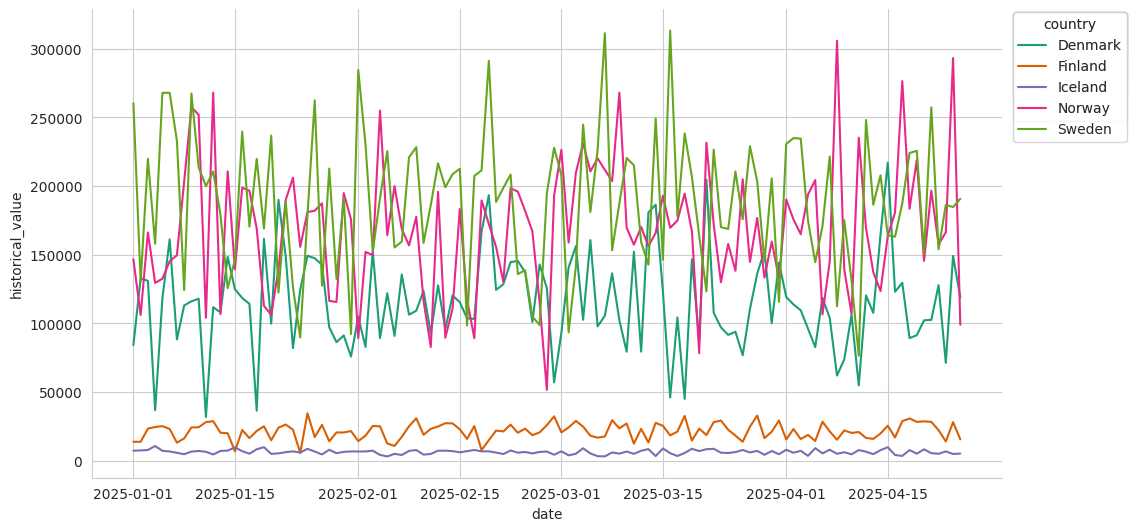

In [38]:
# @title date vs historical_value

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['historical_value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_SQL.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('country')):
  _plot_series(series, series_name, i)
  fig.legend(title='country', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('historical_value')

In [45]:
sql_ca =  '''
    SELECT
    customers.country,
    orders_dp.order_month, -- This is our order date
    SUM(orders_dp.total_amount) AS total_sales -- This is the value we are forecasting
    FROM
    `esdemo-389207`.`retail_data`.`customers` AS customers
    INNER JOIN
    `esdemo-389207`.`retail_data`.`orders_dp` AS orders_dp
    ON customers.customer_id = orders_dp.customer_id
    #WHERE customers.country = 'Sweden' -- <<< PARAMETER: Specify the country to visualize
    GROUP BY
    1,
    2
    '''

query_SQL = client.query(sql_ca)

job_SQL= client.get_job(query_SQL.job_id)
df_ca = job_SQL.to_dataframe()
df_ca

,country,order_month,total_sales
0,Denmark,2025-01,3492021.18
1,Denmark,2025-04,2757162.38
2,Denmark,2025-03,3644126.15
3,Denmark,2025-02,3344826.87
4,Finland,2025-03,700783.46
5,Finland,2025-02,600203.90
6,Finland,2025-01,641617.10
7,Finland,2025-04,536703.95
8,Iceland,2025-01,214830.30
9,Iceland,2025-03,191634.05


In [46]:
# prompt: I have the data in this dataframe df_ca and want to use 80% of this data for training contribution analysis model and 20% for testing. Help me add a column to this which represents training and testing data

import pandas as pd
import numpy as np

# Calculate the split index
split_index = int(len(df_ca) * 0.8)

# Create the 'data_split' column
df_ca['data_split'] = np.where(df_ca.index < split_index, 'training', 'testing')

df_ca

,country,order_month,total_sales,data_split
0,Denmark,2025-01,3492021.18,training
1,Denmark,2025-04,2757162.38,training
2,Denmark,2025-03,3644126.15,training
3,Denmark,2025-02,3344826.87,training
4,Finland,2025-03,700783.46,training
5,Finland,2025-02,600203.90,training
6,Finland,2025-01,641617.10,training
7,Finland,2025-04,536703.95,training
8,Iceland,2025-01,214830.30,training
9,Iceland,2025-03,191634.05,training


In [47]:
# prompt: convert data_split column in df_ca to boolean and set true for test data and false for training data

df_ca['data_split'] = df_ca['data_split'] == 'testing'
df_ca

,country,order_month,total_sales,data_split
0,Denmark,2025-01,3492021.18,False
1,Denmark,2025-04,2757162.38,False
2,Denmark,2025-03,3644126.15,False
3,Denmark,2025-02,3344826.87,False
4,Finland,2025-03,700783.46,False
5,Finland,2025-02,600203.90,False
6,Finland,2025-01,641617.10,False
7,Finland,2025-04,536703.95,False
8,Iceland,2025-01,214830.30,False
9,Iceland,2025-03,191634.05,False


In [48]:
# prompt: Using dataframe df_ca: create a contribution analysis model for this data similar to CREATE OR REPLACE MODEL bqml_tutorial.iowa_liquor_sales_sum_model
#   OPTIONS(
#     model_type='CONTRIBUTION_ANALYSIS',
#     contribution_metric = 'sum(total_sales)',
#     dimension_id_cols = ['store_name', 'city', 'vendor_name', 'category_name',
#       'item_description'],
#     is_test_col = 'is_test',
#     min_apriori_support=0.05
#   ) AS
# SELECT * FROM bqml_tutorial.iowa_liquor_sales_sum_data;

import pandas as pd
import pandas_gbq
from google.cloud import bigquery

# Assuming df_ca is already loaded as a Pandas DataFrame


# Upload the DataFrame to BigQuery
project_id = "esdemo-389207"  # Replace with your project ID
dataset_id = "retail_data" # Replace with your desired dataset ID
table_id = "sales_customers_ca" # Replace with your desired table ID

df_ca.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists='replace')


# Create the contribution analysis model in BigQuery
client = bigquery.Client(project=project_id)

query = f"""
CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.sales_ca_contribution_model`
OPTIONS(
    model_type='CONTRIBUTION_ANALYSIS',
    contribution_metric = 'sum(total_sales)',
    dimension_id_cols = ['country','order_month'],  # Dimensions for analysis
    is_test_col = 'data_split',  # Column indicating training or testing data
    min_apriori_support=0.05  # Adjust as needed. Lower values find more patterns but increase processing time.
) AS
SELECT * FROM `{project_id}.{dataset_id}.{table_id}`;
"""
query_job = client.query(query)
query_job.result()  # Wait for the model creation to complete


print(f"Contribution analysis model created at: {project_id}.{dataset_id}.sales_ca_contribution_model")

<ipython-input-48-db9d1c95b33c>:24: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_ca.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]


Contribution analysis model created at: esdemo-389207.retail_data.sales_ca_contribution_model


In [49]:
# @title Get Insights from Contribution Analysis Model using ML.Get_Insights function

ca_sql = '''
  SELECT
  contributors,
  metric_test,
  metric_control,
  difference,
  relative_difference,
  unexpected_difference,
  relative_unexpected_difference,
  apriori_support,
  contribution
FROM
  ML.GET_INSIGHTS(
    MODEL `esdemo-389207.retail_data.sales_ca_contribution_model`);
    '''


query_SQL = client.query(ca_sql)

# store the destination to reference in future cells
query_destination_SQL = query_SQL.destination.project + '.' + query_SQL.destination.dataset_id + '.' + query_SQL.destination.table_id

#  Render the query results
job_SQL= client.get_job(query_SQL.job_id)
ca_sql = job_SQL.to_dataframe()
ca_sql


,contributors,metric_test,metric_control,difference,relative_difference,unexpected_difference,relative_unexpected_difference,apriori_support,contribution
0,[country=Sweden],21696200.34,0.00,21696200.34,NaN,2.169620e+07,NaN,1.000000,21696200.34
1,[country=Norway],0.00,19398815.16,-19398815.16,-1.000000,-2.557934e+07,-1.000000,0.541069,19398815.16
2,[all],21696200.34,35852742.14,-14156541.80,-0.394852,-1.415654e+07,-0.394852,1.000000,14156541.80
3,[country=Denmark],0.00,13238136.58,-13238136.58,-1.000000,-1.270052e+07,-1.000000,0.369236,13238136.58
4,"[country=Sweden, order_month=2025-03]",5955352.32,0.00,5955352.32,NaN,5.955352e+06,NaN,0.274488,5955352.32
5,"[country=Sweden, order_month=2025-01]",5766141.17,0.00,5766141.17,NaN,5.766141e+06,NaN,0.265767,5766141.17
6,"[country=Norway, order_month=2025-03]",0.00,5520030.28,-5520030.28,-1.000000,-3.948334e+06,-1.000000,0.153964,5520030.28
7,"[country=Sweden, order_month=2025-02]",5335597.30,0.00,5335597.30,NaN,5.335597e+06,NaN,0.245923,5335597.30
8,"[country=Norway, order_month=2025-01]",0.00,5146796.27,-5146796.27,-1.000000,-3.636622e+06,-1.000000,0.143554,5146796.27
9,"[country=Sweden, order_month=2025-04]",4639109.55,0.00,4639109.55,NaN,4.639110e+06,NaN,0.213821,4639109.55


In [ ]:
# @title TimesFM Model in BigQuery for Time Series Forecasting using AI.Forecast function
from google.cloud import bigquery
from google.colab import data_table

project = 'esdemo-389207' # Project ID
client = bigquery.Client(project=project)
data_table.enable_dataframe_formatter()
# @title Executes the query, using client from previous cell
sql_SQL = '''-- This query combines historical sales data with forecasted values for visualization.

WITH historical_sales AS (
  -- This CTE prepares the aggregated historical sales data for a specific city and country.
  SELECT
    customers.country,
    orders_dp.order_date, -- This is our timestamp
    SUM(orders_dp.total_amount) AS total_sales -- This is the value we are forecasting
  FROM
    `esdemo-389207`.`retail_data`.`customers` AS customers
  INNER JOIN
    `esdemo-389207`.`retail_data`.`orders_dp` AS orders_dp
    ON customers.customer_id = orders_dp.customer_id
  #WHERE customers.country = 'Sweden' -- <<< PARAMETER: Specify the country to visualize
  GROUP BY
    1,
    2
),

forecast_data AS (
  -- This CTE generates the forecast
  SELECT
    *
  FROM
    AI.FORECAST(
      (
        SELECT
          country, -- Keep for consistency
          order_date,
          total_sales
        FROM
          historical_sales -- Use the already filtered historical data
      ),
      horizon => 60, -- Match the horizon from your forecasting query
      confidence_level => 0.90, -- Match the confidence level
      timestamp_col => 'order_date',
      data_col => 'total_sales',
      id_cols => ['country'] -- Use id_cols as per your working query
    )
)

-- Combine historical and forecasted data
SELECT
  h.order_date AS date, -- Date column
  h.country,
  h.total_sales AS historical_value, -- Actual historical sales
  NULL AS forecast_value, -- No forecast value for historical points
  'historical' AS type, -- Label for the data type
  NULL AS prediction_interval_lower_bound, -- No prediction interval for historical
  NULL AS prediction_interval_upper_bound -- No prediction interval for historical
FROM
  historical_sales h
  -- Optional: Limit the number of historical points shown for cleaner visualization
  -- ORDER BY h.order_date DESC
  -- LIMIT 400

UNION ALL

SELECT
  extract(date from f.forecast_timestamp) AS date, -- Date column from forecast
  f.country, -- Country from forecast output
  NULL AS historical_value, -- No historical value for forecast points
  f.forecast_value AS forecast_value, -- The forecasted sales value
  'forecast' AS type, -- Label for the data type
  f.prediction_interval_lower_bound, -- Lower bound of the prediction
  f.prediction_interval_upper_bound -- Upper bound of the prediction
FROM
  forecast_data f

ORDER BY
  date ASC, type; -- Order by date to show chronological progression
'''
query_SQL = client.query(sql_SQL)

# store the destination to reference in future cells
query_destination_SQL = query_SQL.destination.project + '.' + query_SQL.destination.dataset_id + '.' + query_SQL.destination.table_id

#  Render the query results
job_SQL= client.get_job(query_SQL.job_id)
df_SQL = job_SQL.to_dataframe()
df_SQL


,date,country,historical_value,forecast_value,type,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2025-01-01,Iceland,7331.05,NaN,historical,NaN,NaN
1,2025-01-01,Norway,146706.71,NaN,historical,NaN,NaN
2,2025-01-01,Finland,13858.84,NaN,historical,NaN,NaN
3,2025-01-01,Sweden,260427.82,NaN,historical,NaN,NaN
4,2025-01-01,Denmark,84148.62,NaN,historical,NaN,NaN
...,...,...,...,...,...,...,...
870,2025-06-24,Denmark,NaN,121146.898438,forecast,37145.727208,205148.069667
871,2025-06-24,Iceland,NaN,4738.885742,forecast,985.973893,8491.797592
872,2025-06-24,Norway,NaN,119872.765625,forecast,11551.007125,228194.524125
873,2025-06-24,Finland,NaN,20032.097656,forecast,6204.460554,33859.734758


create a time series to plot historical and forecasted sales to compare Sweden and Norway

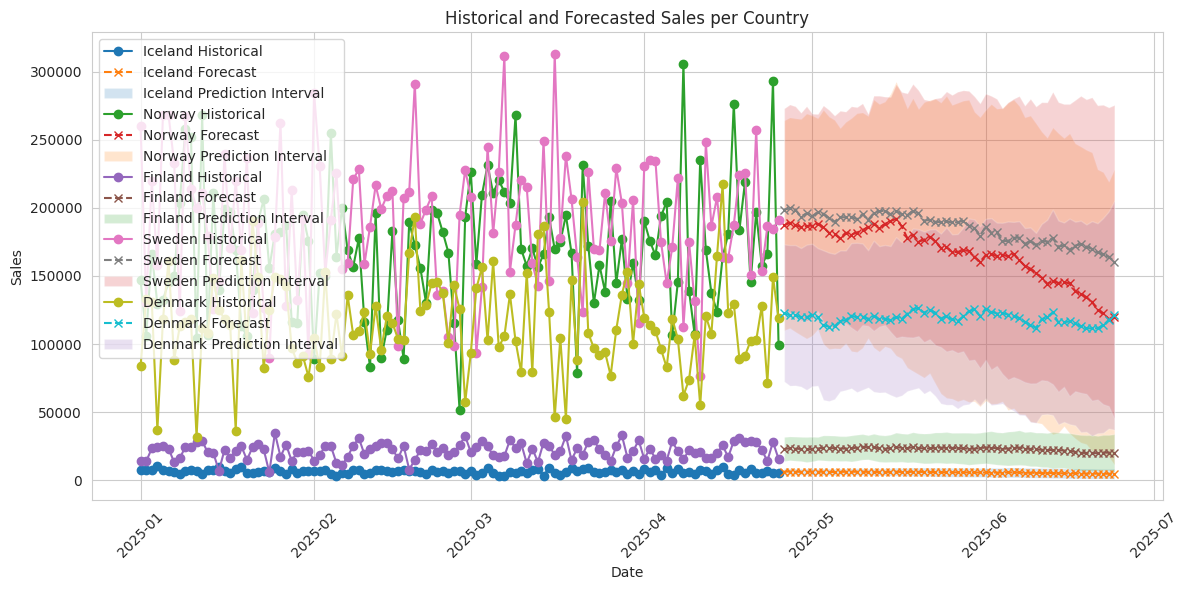

In [ ]:
# prompt: create a time series to plot historical and forecasted sales per country

import pandas_gbq
import matplotlib.pyplot as plt
import seaborn as sns

# Use the existing dataframe `df_SQL` from the previous cell

def plot_historical_and_forecasted_sales(df):
    """Plots historical and forecasted sales per country."""

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for country in df['country'].unique():
        country_df = df[df['country'] == country].sort_values('date')

        plt.plot(country_df['date'], country_df['historical_value'], label=f'{country} Historical', marker='o', linestyle='-')
        plt.plot(country_df['date'], country_df['forecast_value'], label=f'{country} Forecast', marker='x', linestyle='--')

        # Fill between prediction intervals if available
        if 'prediction_interval_lower_bound' in country_df.columns and 'prediction_interval_upper_bound' in country_df.columns:
          plt.fill_between(
              country_df['date'],
              country_df['prediction_interval_lower_bound'],
              country_df['prediction_interval_upper_bound'],
              alpha=0.2,
              label=f'{country} Prediction Interval'
          )


    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Historical and Forecasted Sales per Country')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_historical_and_forecasted_sales(df_SQL)